In [1]:
print('Start import')
import socket 
import strax
import straxen
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime
import pandas as pd
print(
f'''Working on {socket.getfqdn()} with the following versions 
and installation paths:
strax
\tv{strax.__version__}\t{str(strax.__path__[0])}
straxen
\tv{straxen.__version__}\t{str(straxen.__path__[0])}
''')
from multihist import Hist1d, Histdd
import time
import itertools
import os

from scipy import stats
from straxen import units
from scipy.optimize import curve_fit

import peaks_utility as psu
import drift_diffusion_utility as ddu
import math

Start import
Working on midway2-0417.rcc.local with the following versions 
and installation paths:
strax
	v0.15.3	/dali/lgrandi/strax/strax/strax
straxen
	v0.18.8	/dali/lgrandi/strax/straxen/straxen



In [2]:
st = straxen.contexts.xenonnt_online()

In [3]:
dsets = st.select_runs(exclude_tags=('bad','messy','abandon','flash',
                                     'ramp down','hev test','_messy'),
                       run_mode='ambe_linked_hev',
                       available=('events','peak_basics'))

Checking data availability: 100%|██████████| 3/3 [02:02<00:00, 40.77s/it]


In [4]:
dsets

,name,number,mode,end,start,tags,livetime,events_available,raw_records_available,peak_basics_available
1487,020479,20479,ambe_linked_hev,2021-05-27 09:39:38.209,2021-05-27 09:13:31.927,hot spot,0 days 00:26:06.282000,True,False,True
1488,020478,20478,ambe_linked_hev,2021-05-27 09:12:40.885,2021-05-27 09:04:03.420,hot spot,0 days 00:08:37.465000,True,False,True
1519,020447,20447,ambe_linked_hev,2021-05-27 07:15:19.945,2021-05-27 06:53:37.695,"_sr0_preliminary,ambe_source_bottom_cw11d2m",0 days 00:21:42.250000,True,False,True
1520,020446,20446,ambe_linked_hev,2021-05-27 06:53:22.025,2021-05-27 06:23:21.039,"_sr0_preliminary,ambe_source_bottom_cw11d2m",0 days 00:30:00.986000,True,False,True
1521,020445,20445,ambe_linked_hev,2021-05-27 06:23:01.760,2021-05-27 05:52:59.730,"_sr0_preliminary,ambe_source_bottom_cw11d2m",0 days 00:30:02.030000,True,False,True
...,...,...,...,...,...,...,...,...,...,...
1582,020384,20384,ambe_linked_hev,2021-05-26 00:37:38.947,2021-05-26 00:07:36.627,"_sr0_preliminary,ambe_source_top_cw5d9",0 days 00:30:02.320000,True,False,True
1583,020383,20383,ambe_linked_hev,2021-05-26 00:07:17.175,2021-05-25 23:37:14.334,"_sr0_preliminary,ambe_source_top_cw5d9",0 days 00:30:02.841000,True,False,True
1584,020382,20382,ambe_linked_hev,2021-05-25 23:36:55.036,2021-05-25 23:06:54.519,"_sr0_preliminary,ambe_source_top_cw5d9",0 days 00:30:00.517000,True,False,True
1585,020381,20381,ambe_linked_hev,2021-05-25 23:06:38.815,2021-05-25 22:36:38.211,"_sr0_preliminary,ambe_source_top_cw5d9",0 days 00:30:00.604000,True,False,True


In [11]:
AmBe_runs = np.array(dsets['name'])

In [12]:
AmBe_runs

array(['021463', '021461', '021459', '021457', '021455', '021453',
       '021451', '021449', '021447', '021445', '021443', '021441',
       '021439', '021437', '021435', '021433', '021431', '021429',
       '021427', '021425', '021423', '021421', '021419', '021417',
       '021415', '021413', '021411', '021409', '021407', '021405',
       '021403', '021401', '021399', '021397', '021395', '021393',
       '021391', '021389', '021387', '021385', '021383', '021381',
       '021379', '021377', '021375', '021373', '021371', '021369',
       '021367', '021365', '021363', '021361', '021359', '021357',
       '021355', '021353', '021349', '021347', '021345', '021343',
       '021341', '021339', '021337', '021335', '021333', '021331',
       '021329', '021327', '021325', '021323', '021320', '021318',
       '021316', '021314', '021312', '021310', '021308', '021306',
       '021304', '021302', '021300', '021298', '021296', '021294',
       '021292', '021290', '021288', '021286', '020331', '0203

In [13]:
def diffusion_analysis(run_, vd = 0.677, vd_err = 0.006, area_cut=(1e4,5e6), fit_range=(1,1500), plot = False ):
    run = int(run_)
    events = st.get_df(run_,'event_info',progress_bar=False)
    if(plot): ddu.plot_area_width_aft(events, run_)
    mask_awt = ddu.mask_s2_area_width_aft(events,run_,area_cut,width_cut=(200,1.5e4),aft_cut=(0.65,0.77),high=7,plot=plot)
    e1 = events[mask_awt]
    vd, vd_err, cathodedt, gatedt, s2shift = ddu.drift_velocity(e1, run_, low=100,catlim=2000, plot=plot)
    d, d_err, par, par_err = ddu.diffusion_constant(e1,run_,fit_range=(200,1500),vd = vd,plot=plot)
    return run, vd, vd_err, d, d_err, par, par_err

Drift velocity = 0.747~mm/$\mu$s
Diffusion constant = 9.52 +/- 7.15 cm$^2$/s 


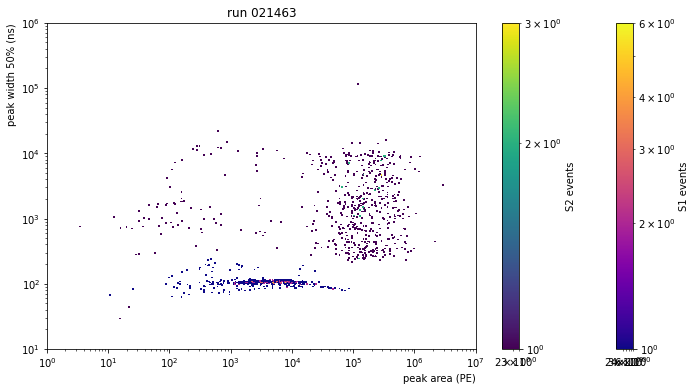

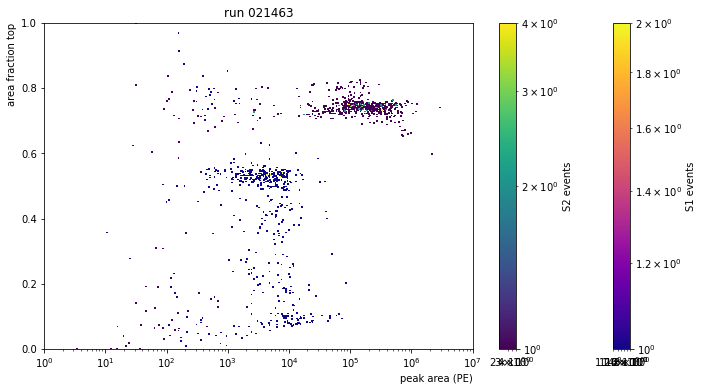

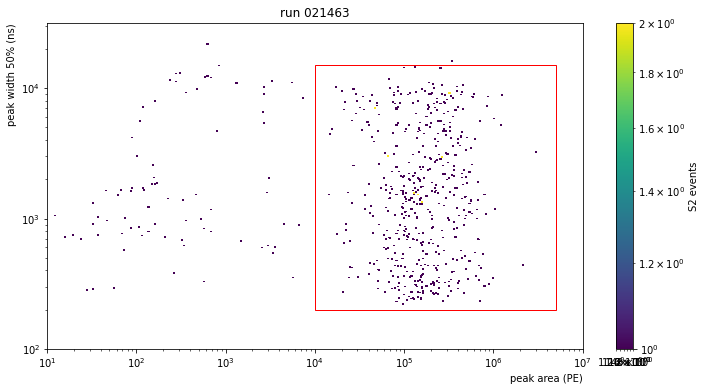

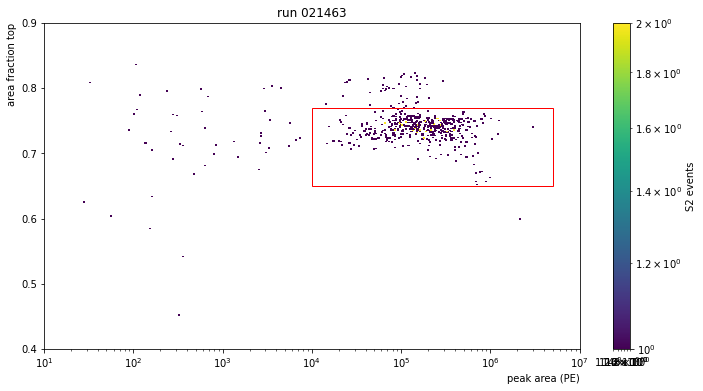

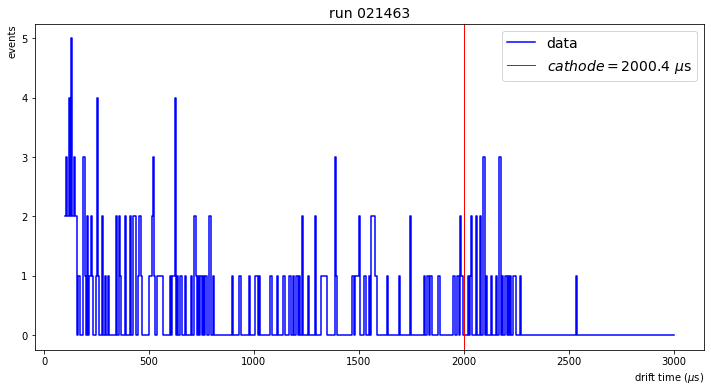

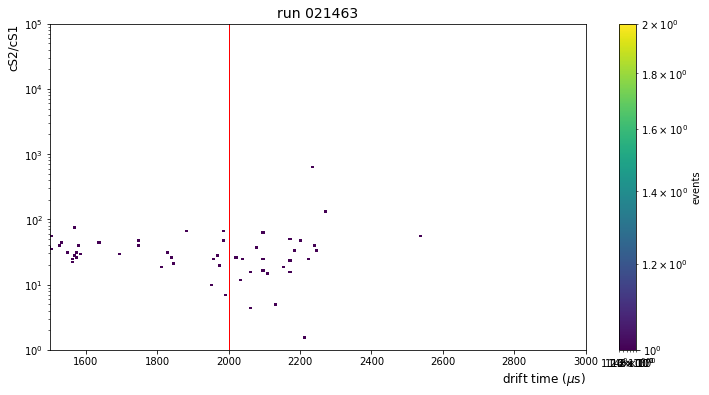

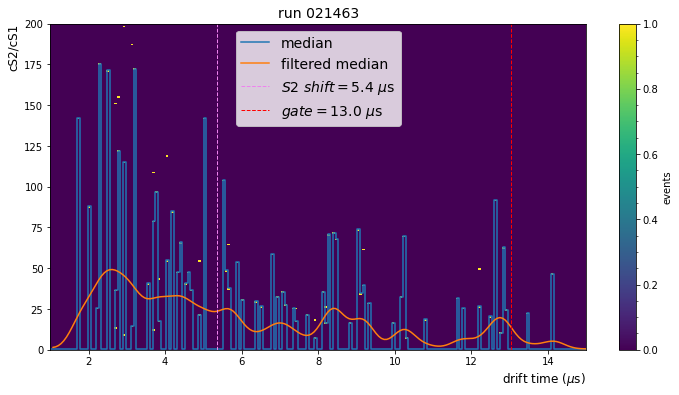

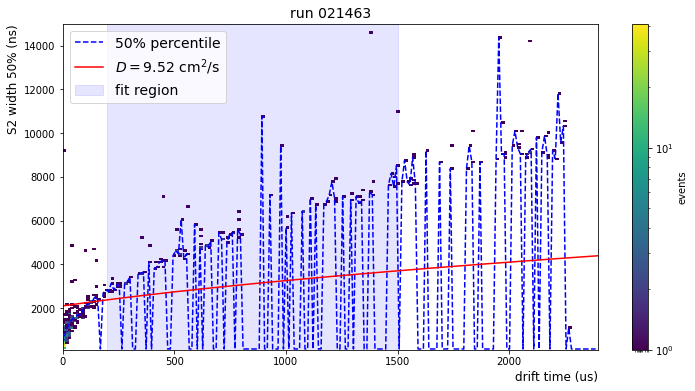

In [14]:
run, vd, vd_err, d, d_err, par, par_err = diffusion_analysis(AmBe_runs[0],area_cut=(1e4,5e6),fit_range=(1,1500), plot = True)

Drift velocity = 0.679~mm/$\mu$s
Diffusion constant = 44.90 +/- 0.10 cm$^2$/s 


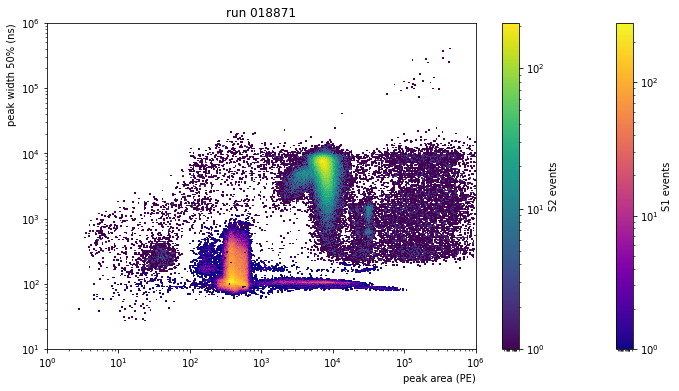

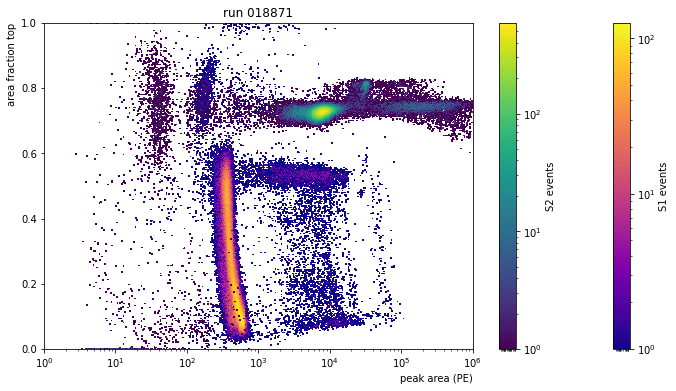

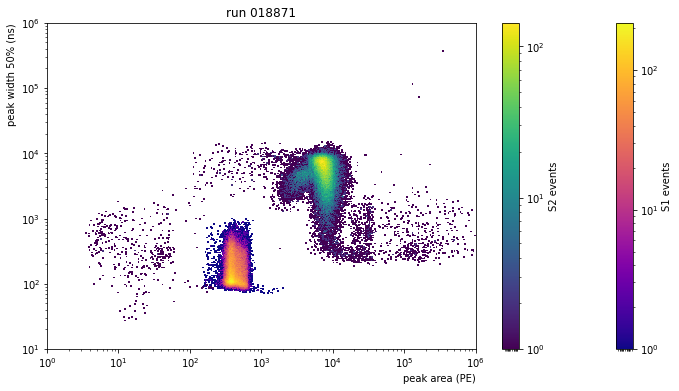

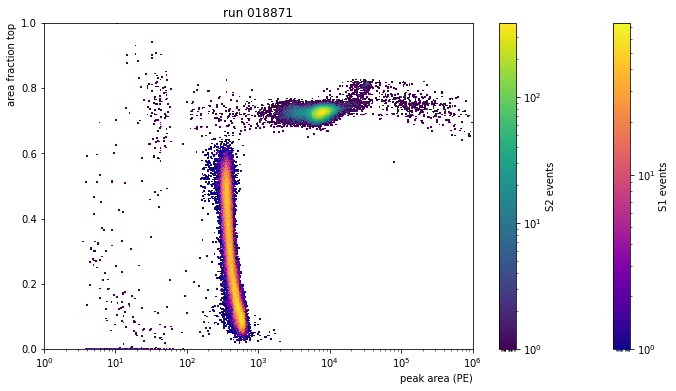

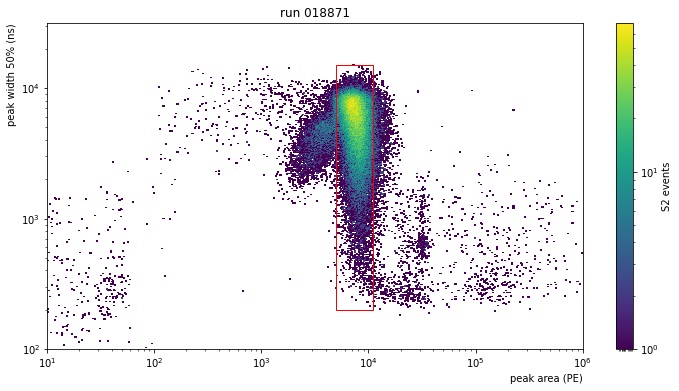

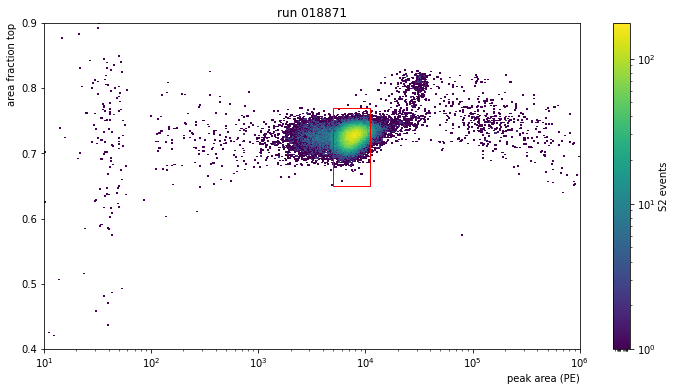

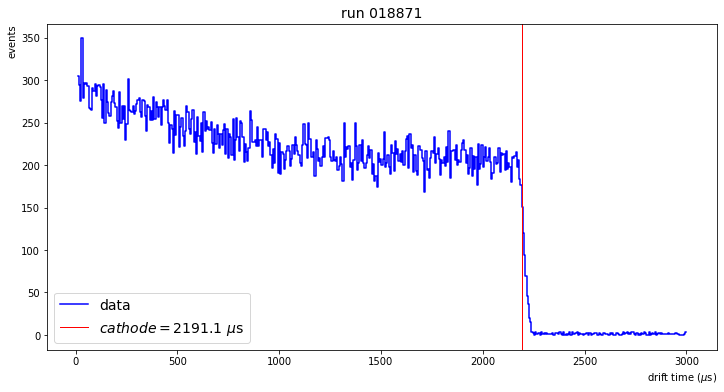

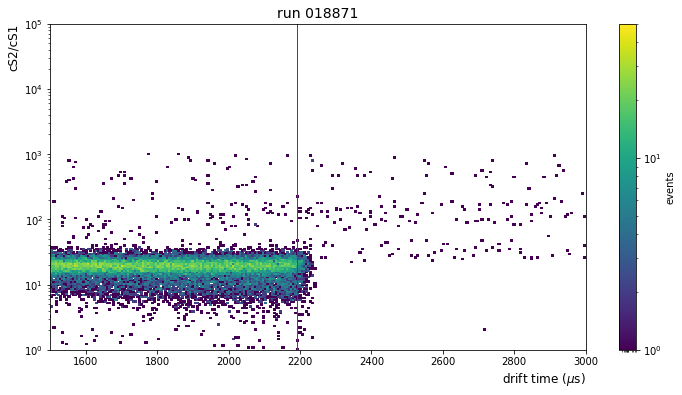

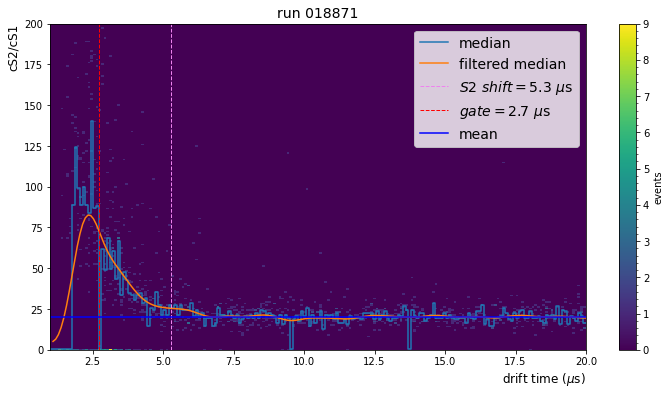

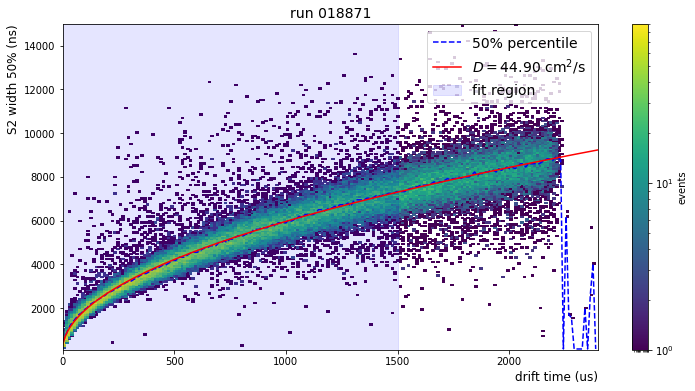

In [9]:
runk, vdk, vd_errk, dk, d_errk, cathodedtk, gatedtk, s2shiftk, park, park_err = ddu.diffusion_analysis_kr(st, run_kr='018871', area_cut=(5e3,1.1e4), plot = 1 )

In [15]:
def merge_runs(runs):
    ev0 = st.get_df(runs[0],'event_info',progress_bar=False)
    print('Reading runs from',runs[-1],'to',runs[0])
    start = time.time()
    for i, run_id in enumerate(runs[1:]):
        if ((i+1)%5) == 0: print(f'n. {i} run {run_id} elapsed time: {time.time()-start:.2f} s')
        ev_temp = st.get_df(run_id,'event_info',progress_bar=False)
        frames = [ev0,ev_temp]
        ev0 = pd.concat(frames)
    return ev0

In [ ]:
ev0 = merge_runs(AmBe_runs)

Reading runs from 020280 to 021463
n. 4 run 021453 elapsed time: 0.96 s
n. 9 run 021443 elapsed time: 2.77 s


/dali/lgrandi/strax/straxen/straxen/mongo_storage.py:332: UserWarning: Downloading XnT_3D_FDC_xyt_MLP_v0.1_B2d75n_C2d75n_G0d3p_A4d9p_T0d9n_PMTs1d3n_FSR0d65p.json.gz to ./resource_cache/b64458dd2700626709b76374059f5c88
  warn(f'Downloading {config_name} to {destination_path}')
/dali/lgrandi/strax/straxen/straxen/mongo_storage.py:332: UserWarning: Downloading XnT_S1_xyz_MLP_v0.1_B2d75n_C2d75n_G0d3p_A4d9p_T0d9n_PMTs1d3n_FSR0d65p_v0d677.json to ./resource_cache/d70b7dbdf7b3853b1559c667bc01cb06
  warn(f'Downloading {config_name} to {destination_path}')
/dali/lgrandi/strax/straxen/straxen/mongo_storage.py:332: UserWarning: Downloading XENONnT_s2_xy_map_v0_20210503_mlp.json to ./resource_cache/6ed9b08fc34099e9c90928e42ae5fe9d
  warn(f'Downloading {config_name} to {destination_path}')


n. 14 run 021433 elapsed time: 19.84 s
n. 19 run 021423 elapsed time: 21.51 s
n. 24 run 021413 elapsed time: 23.45 s
n. 29 run 021403 elapsed time: 25.77 s
n. 34 run 021393 elapsed time: 42.47 s
n. 39 run 021383 elapsed time: 59.26 s
n. 44 run 021373 elapsed time: 63.45 s
n. 49 run 021363 elapsed time: 68.14 s
n. 54 run 021353 elapsed time: 73.70 s
n. 59 run 021341 elapsed time: 81.63 s
n. 64 run 021331 elapsed time: 103.06 s
n. 69 run 021320 elapsed time: 111.22 s
n. 74 run 021310 elapsed time: 119.96 s
n. 79 run 021300 elapsed time: 142.18 s
n. 84 run 021290 elapsed time: 153.49 s
n. 89 run 020329 elapsed time: 165.69 s
n. 94 run 020323 elapsed time: 179.93 s
n. 99 run 020318 elapsed time: 196.90 s
n. 104 run 020313 elapsed time: 213.37 s


In [12]:
from scipy.stats import beta, chi2
from scipy.interpolate import interp1d
mu = 0.725
a = np.logspace(2, 6.5, 201)
_a = np.clip(a, 0, 1e3)
b = beta.isf(0.0001, ((_a * mu) / 1.2).astype(int),((_a - _a * mu) / 1.2).astype(int))
c = beta.isf(0.9999, ((_a * mu) / 1.2).astype(int),((_a - _a * mu) / 1.2).astype(int))
aft_ul = interp1d(a, b, bounds_error=False, fill_value='extrapolate')
aft_ll = interp1d(a, c, bounds_error=False, fill_value='extrapolate')
a = np.logspace(2, 6.5, 201)
_a = np.clip(np.logspace(2, 6.5, 201), 0, 1e3)
b = chi2.isf(0.1, _a / 40) / (_a / 40)
c = chi2.isf(0.9, _a / 40) / (_a / 40)
s2w_ul = interp1d(a, b, bounds_error=False, fill_value='extrapolate')
s2w_ll = interp1d(a, c, bounds_error=False, fill_value='extrapolate')

def basic_cuts(data):
    cut = np.ones(len(data), dtype=bool)
    cut &= data['drift_time'] > 2.0e3
    cut &= data['s2_area'] > 100
    cut &= data['z'] > -144
    cut &= data['r'] < 70 # 55
    cut_basics = np.ones(len(data), dtype=bool)
    cut_basics[:] = cut.copy()
    cut &= data['z'] < -2
    cut &= data['s1_area_fraction_top'] < 0.6 # conservative
    cut &= data['alt_s2_area'] < np.clip(data['s2_area']*0.005, 80, np.inf)
    cut &= data['s2_area_fraction_top'] < aft_ul(data['s2_area'])
    cut &= data['s2_area_fraction_top'] > aft_ll(data['s2_area'])
    return cut

In [13]:
def S2WidthCut_percentile(ev0,runs, vd = 0.675, par_kr = (44.4, 0.675, 341), wrange = (500,15000),
                          fit_range = (200,1500), perc = (10,80) ):
    #events = ev0[(ev0['s2_range_50p_area'] > wrange[0]) &
    #             (ev0['s2_range_50p_area'] < wrange[1])]
                 #(ev0['s2_area'] > arange[0]) & (ev0['s2_area'] < arange[1]) &
                 #(ev0['s2_area_fraction_top'] > aft_range[0]) & 
                 #(ev0['s2_area_fraction_top'] < aft_range[1])]
    #pre_sel1 = pre1[0]*ev1['drift_time']/1e3+pre1[1]
    #pre_sel2 = pre2[0]*ev1['drift_time']/1e3+pre2[1]
    #events = ev1[(ev1['s2_range_50p_area'] < pre_sel1) &
    #             (ev1['s2_range_50p_area'] > pre_sel2)]
    events = ev0[basic_cuts(ev0)]
    s2width = events['s2_range_50p_area']
    drift = events['drift_time']/1e3
    s2area = events['s2_area']
    
    print('total events',len(ev0),'selected events',len(events))
    
    t = np.linspace(0, 2400, 200)
    wspace = np.linspace(wrange[0], wrange[1], 200)
    ph = Histdd(drift, s2width, bins=(t, wspace))
    
    # fit 50 percentile
    perc50 = np.array(ph.percentile(percentile=50, axis=1))
    D_guess = 45e3 * units.cm**2 / units.s
    w0_guess = 500 * units.ns
    vd = vd * units.mm / units.us
    guess = np.array([D_guess, vd, w0_guess])
    ll = np.where(t>fit_range[0])[0][0]
    hh = np.where(t>fit_range[1])[0][0]
    diffusion = lambda x, D, w0: ddu.diffusion_model(x, D, vd, w0)
    par, pcov = curve_fit(diffusion, t[ll:hh], perc50[ll:hh], p0=(D_guess, w0_guess))
    perr = np.sqrt(np.diag(pcov))
    ys = diffusion(t, *par)
    
    D_kr = par_kr[0] * 1e3 * units.cm**2 / units.s
    w0_kr = par_kr[2] * units.ns
    vd_kr = par_kr[1] * units.mm / units.us
    ys_kr = ddu.diffusion_model(t, D_kr, vd_kr, w0_kr)
    
    plt.figure(figsize=(12,6))
    ph.plot(log_scale=True, cblabel='events')
    #plt.axvspan(*fit_range, alpha=0.1, color='blue', label='fit region')
    #plt.plot((t[1:]+t[:-1])/2, perc50, color='b',linestyle='--', label='50% percentile')
    plt.plot(t, ys, 'r--',label=f'fit: $D = {par[0]/1e3/(units.cm**2 / units.s):.2f}$ cm$^2$/s')
    plt.plot(t, ys_kr, 'b--',label=f'Kr-83m: $D = {par_kr[0]:.2f}$ cm$^2$/s')
    plt.xlabel("drift time (us)", ha='right', x=1,fontsize=12)
    plt.ylabel("S2 width 50% (ns)", ha='right', y=1,fontsize=12)
    plt.title(f'run{runs[0]} - {runs[-1]}',fontsize=14)
    plt.legend(fontsize=14)
    
    #plt.figure(figsize=(12,6))
    #ev = events[(s2width > diffusion(drift, *pard)) & (s2width < diffusion(drift, *paru))]
    #phh = Histdd(ev['drift_time']/1e3, ev['s2_range_50p_area'],bins=(t, wspace))
    #phh.plot(log_scale=True, cblabel='events')
    #plt.xlabel("drift time (us)", ha='right', x=1,fontsize=12)
    #plt.ylabel("S2 width 50% (ns)", ha='right', y=1,fontsize=12)
    #plt.title(f'run{runs[0]} - {runs[-1]}',fontsize=14)
    
    #normalized width using D from fit
    #norm50a = ev['s2_range_50p_area']/diffusion(ev['drift_time']/1e3, *par)
    norm50b = events['s2_range_50p_area']/diffusion(events['drift_time']/1e3, *par)
    aspace = np.logspace(2.5, 7, 200)
    nspace = np.linspace(0, 6, 200)
    #pha = Histdd(ev['s2_area'], norm50a, bins=(aspace, nspace))
    phb = Histdd(events['s2_area'], norm50b, bins=(aspace, nspace))
    plt.figure(figsize=(12,6))
    #pha.plot(log_scale=True, cblabel='events after S2WidthCut',cmap='plasma')
    phb.plot(log_scale=True, cblabel='events')#,alpha=0.2)
    perc90b = np.array(phb.percentile(percentile=99, axis=1))
    perc10b = np.array(phb.percentile(percentile=1, axis=1))
    plt.plot((aspace[1:]+aspace[:-1])/2, perc90b, 'r--', label='99% percentile')
    plt.plot((aspace[1:]+aspace[:-1])/2, perc10b, 'r--', label='1% percentile')
    plt.axhline(y=1,c='black',ls='--',label='model from fit')
    plt.xlabel("S2 area (PE)", ha='right', x=1,fontsize=12)
    plt.ylabel("Normalized S2 width 50% (ns)", ha='right', y=1,fontsize=12)
    plt.title(f'run{runs[0]} - {runs[-1]}',fontsize=14)
    plt.xscale('log')
    plt.legend(fontsize=14)
    
    #normalized width using D from Kr-83m
    norm50a = events['s2_range_50p_area']/ddu.diffusion_model(events['drift_time']/1e3, D_kr, vd_kr, w0_kr)
    aspace = np.logspace(2.5, 7, 200)
    nspace = np.linspace(0, 6, 200)
    pha = Histdd(events['s2_area'], norm50a, bins=(aspace, nspace))
    plt.figure(figsize=(12,6))
    pha.plot(log_scale=True, cblabel='events')
    perc90a = np.array(pha.percentile(percentile=99, axis=1))
    perc10a = np.array(pha.percentile(percentile=1, axis=1))
    plt.plot((aspace[1:]+aspace[:-1])/2, perc90a, 'r--', label='99% percentile')
    plt.plot((aspace[1:]+aspace[:-1])/2, perc10a, 'r--', label='1% percentile')
    plt.axhline(y=1,c='black',ls='-',label='model from Kr-83m')
    plt.xlabel("S2 area (PE)", ha='right', x=1,fontsize=12)
    plt.ylabel("Normalized S2 width 50% (ns)", ha='right', y=1,fontsize=12)
    plt.title(f'run{runs[0]} - {runs[-1]}',fontsize=14)
    plt.xscale('log')
    plt.legend(fontsize=14)

total events 2107774 selected events 468170


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


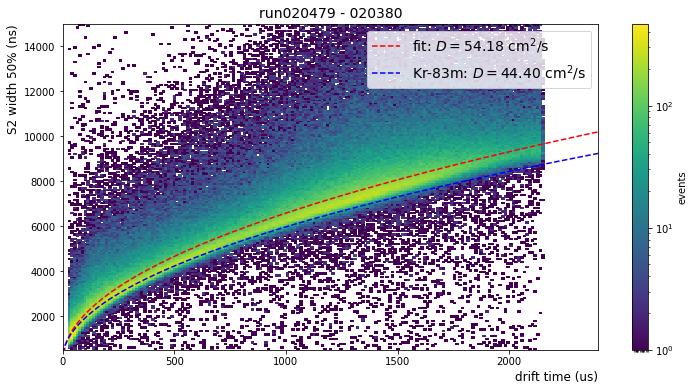

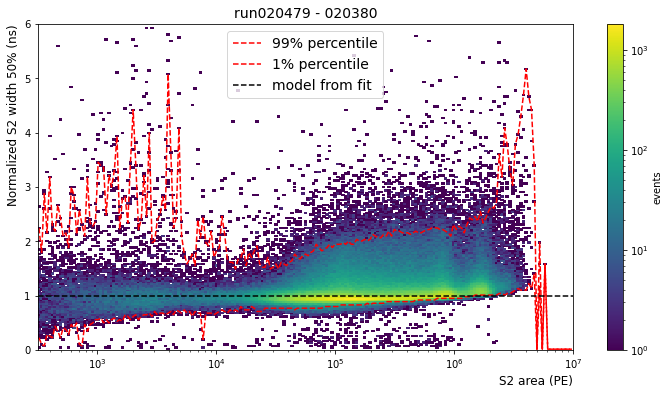

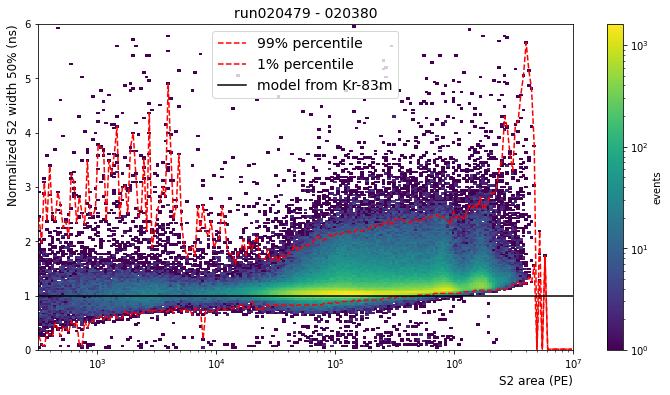

In [14]:
S2WidthCut_percentile(ev0, AmBe_runs)

In [15]:
def S2WidthCut(ev0,run_id, D, Dd, Du, w0, w0d, w0u, alo, ahi, vd = 0.671, plot = False):
    plt.figure(figsize=(12,6))
    for i in range(len(D)):
        aspace = np.logspace(2, 7, 200)
        nspace = np.linspace(0, 6, 200)
        ev1 = ev0[(ev0['s2_area']> alo[i]) & (ev0['s2_area'] <= ahi[i])]
        norm50b = ev1['s2_range_50p_area']/ddu.diffusion_model(ev1['drift_time']/1e3, D[i]*1e8,vd,w0[i])
        phb = Histdd(ev1['s2_area'], norm50b, bins=(aspace, nspace))
        if i == 0: phb.plot(log_scale=True, cblabel='events before S2WidthCut',alpha=0.2)
        else: phb.plot(log_scale=True, cblabel='events before S2WidthCut',alpha=0.2,colorbar=False)            
        width1 = ev1['s2_range_50p_area']
        drift1 = ev1['drift_time']/1e3
        
        ev = ev1[(width1 > ddu.diffusion_model(drift1,Dd[i]*1e8,vd,w0d[i])) &
                 (width1 < ddu.diffusion_model(drift1,Du[i]*1e8,vd,w0u[i]))]
        
        print('region',i,'total events',len(ev1),'selected events',len(ev))
        #normalized width
        norm50a = ev['s2_range_50p_area']/ddu.diffusion_model(ev['drift_time']/1e3, D[i]*1e8,vd,w0[i])
        #limd = ddu.diffusion_model(ev0['drift_time']/1e3, Dd[i]*1e8,vd,w0d[i])/ddu.diffusion_model(ev0['drift_time']/1e3, D[i]*1e8,vd, w0[i])
        #limu = ddu.diffusion_model(ev0['drift_time']/1e3, Du[i]*1e8,vd,w0u[i])/ddu.diffusion_model(ev0['drift_time']/1e3, D[i]*1e8,vd, w0[i])
        pha = Histdd(ev['s2_area'], norm50a, bins=(aspace, nspace))
        #phd = Histdd(ev0['s2_area'], limd, bins=(aspace, nspace))
        #phu = Histdd(ev0['s2_area'], limu, bins=(aspace, nspace))
        #medd = np.array(phd.percentile(percentile=50, axis=1))
        #medu = np.array(phu.percentile(percentile=50, axis=1))
        if i == 0: pha.plot(log_scale=True, cblabel='events after S2WidthCut',cmap='plasma')
        else: pha.plot(log_scale=True, cblabel='events after S2WidthCut',cmap='plasma',colorbar=False)
        #plt.plot((aspace[1:]+aspace[:-1])/2,medd,c='black',ls='--',label='2$\sigma$ limit')
        #plt.plot((aspace[1:]+aspace[:-1])/2,medu,c='black',ls='--')
    plt.axhline(y=1,c='r',ls='--',label='median model')
    plt.xlabel("S2 area (PE)", ha='right', x=1,fontsize=12)
    plt.ylabel("Normalized S2 width 50% (ns)", ha='right', y=1,fontsize=12)
    #plt.title(f'run{run_id}',fontsize=14)
    plt.xscale('log')
    plt.legend(fontsize=14)

In [16]:
S2WidthCut(ev0,run_id='020380',D=D, Dd=Dd, Du=Du, w0=w0, w0d=w0d, w0u=w0u,alo=alo,ahi=ahi)

NameError: name 'D' is not defined